In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from google.colab import files
import os

!pip install torch pandas numpy matplotlib scikit-learn

print("Please upload your data.csv file.")
uploaded = files.upload() # This will prompt the user to upload data.csv

csv_file_name = "data.csv"
if csv_file_name in uploaded:
    df = pd.read_csv(io.BytesIO(uploaded[csv_file_name]))
    print(f"{csv_file_name} loaded into DataFrame.")
    display(df.head()) # Display the head of the DataFrame as requested
else:
    print(f"Error: {csv_file_name} not found. Please upload the file.")
    # Creating a dummy DataFrame to prevent further errors if data.csv is not uploaded
    df = pd.DataFrame({'NO2': np.random.rand(100) * 100})

x = df["NO2"].dropna().values.reshape(-1,1)

a_r = 2.0
b_r = 1.2

z = x + a_r * np.sin(b_r * x)

scaler = StandardScaler() # Renamed sclr to scaler for consistency
z_scaled = scaler.fit_transform(z)
z_tensor = torch.tensor(z_scaled, dtype=torch.float32)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(10, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

G = Generator()
D = Discriminator()

loss_fn = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=0.0005)
opt_D = optim.Adam(D.parameters(), lr=0.0005)

epochs = 800
batch_size = 128

for epoch in range(epochs):
    for i in range(0, len(z_tensor), batch_size):
        real = z_tensor[i:i+batch_size]
        if len(real) == 0:
            continue

        n = real.size(0)
        real_label = torch.ones(n,1)
        fake_label = torch.zeros(n,1)

        noise = torch.randn(n,10)
        fake = G(noise)

        out_real = D(real)
        out_fake = D(fake.detach())

        loss_D = loss_fn(out_real, real_label) + loss_fn(out_fake, fake_label)

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        out_fake = D(fake)
        loss_G = loss_fn(out_fake, real_label)

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    if epoch % 100 == 0:
        print("Epoch:", epoch, "D Loss:", loss_D.item(), "G Loss:", loss_G.item())

Please upload your data.csv file.


Saving data.csv to data (1).csv
Error: data.csv not found. Please upload the file.
Epoch: 0 D Loss: 1.3766448497772217 G Loss: 0.6510780453681946
Epoch: 100 D Loss: 1.522627592086792 G Loss: 0.560640811920166
Epoch: 200 D Loss: 1.4544613361358643 G Loss: 0.609091579914093
Epoch: 300 D Loss: 1.2749173641204834 G Loss: 0.7516161203384399
Epoch: 400 D Loss: 1.2181942462921143 G Loss: 0.9057748913764954
Epoch: 500 D Loss: 1.2954161167144775 G Loss: 0.7606807947158813
Epoch: 600 D Loss: 1.52052640914917 G Loss: 0.847697913646698
Epoch: 700 D Loss: 1.4009079933166504 G Loss: 0.8030254244804382


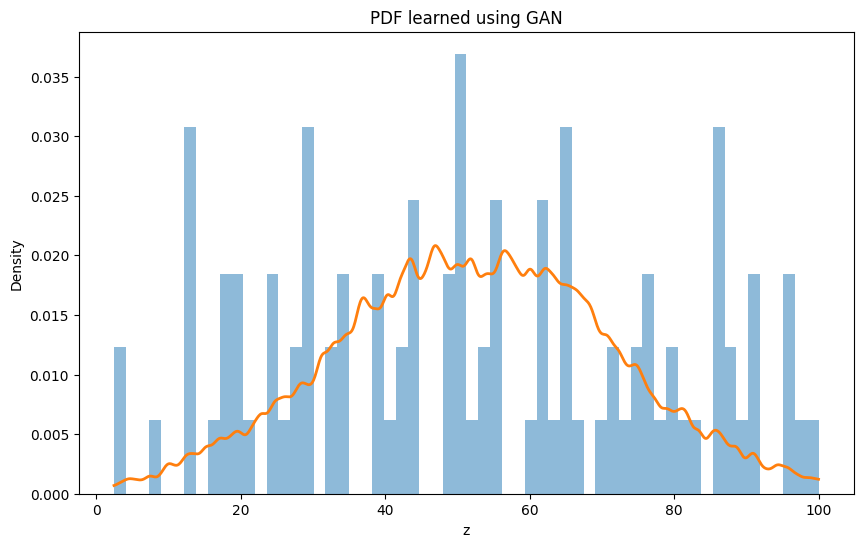

In [5]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

G.eval()

noise = torch.randn(15000, 10)
generated = G(noise).detach().numpy()

generated = scaler.inverse_transform(generated)
real_z = scaler.inverse_transform(z_scaled)

kde = KernelDensity(kernel="gaussian", bandwidth=0.6)
kde.fit(generated)

z_range = np.linspace(real_z.min(), real_z.max(), 1000).reshape(-1,1)
log_density = kde.score_samples(z_range)
pdf = np.exp(log_density)

plt.figure(figsize=(10,6))
plt.hist(real_z, bins=60, density=True, alpha=0.5)
plt.plot(z_range, pdf, linewidth=2)
plt.xlabel("z")
plt.ylabel("Density")
plt.title("PDF learned using GAN")
plt.show()